## Import & Data Load

In [ ]:
# CatBoost 모델 특징
# 특징1.  CatBoost는 카테고리 특성을 자동으로 처리하는 기능
# 특징2. 대용량 데이터셋에서도 잘 작동함
# 특징3. CatBoost는 기본적으로 대칭 트리를 사용하여 과적합을 줄이는 데 도움
# 특징4. CatBoost는 미세 조정 없이도 좋은 성능을 내는 경향이 있음. 하이퍼파라미터 튜닝에 대한 노력을 덜 해도 괜찮음

In [2]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.4 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import catboost


train = pd.read_csv('train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('test.csv').drop(columns=['SAMPLE_ID'])

## Data Pre-processing

In [4]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)


# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

<ipython-input-4-b42cba066898>:20: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.fillna(train.mean(), inplace=True)
<ipython-input-4-b42cba066898>:21: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  test.fillna(train.mean(), inplace=True)


In [5]:
# 기름값의 평균 열 추
train['oil_mean'] = np.mean([train['DUBAI'],train['BRENT'],train['WTI']],axis=0)
test['oil_mean'] = np.mean([test['DUBAI'],test['BRENT'],test['WTI']],axis=0)

## 모델 학습 및 특성 중요도 확인

Model Tune for CatBoost.
Learning rate set to 0.104107
0:	learn: 167.6867074	total: 501ms	remaining: 8m 20s
1:	learn: 165.4146555	total: 909ms	remaining: 7m 33s
2:	learn: 163.4635660	total: 1.3s	remaining: 7m 11s
3:	learn: 161.9116254	total: 1.7s	remaining: 7m 3s
4:	learn: 160.6107704	total: 2.05s	remaining: 6m 48s
5:	learn: 159.3588580	total: 2.4s	remaining: 6m 38s
6:	learn: 158.4591702	total: 2.77s	remaining: 6m 32s
7:	learn: 157.6231682	total: 3.17s	remaining: 6m 33s
8:	learn: 156.9462449	total: 3.56s	remaining: 6m 32s
9:	learn: 156.3307614	total: 4.03s	remaining: 6m 39s
10:	learn: 155.8074118	total: 4.41s	remaining: 6m 36s
11:	learn: 155.3674432	total: 5.16s	remaining: 7m 5s
12:	learn: 154.9813626	total: 5.97s	remaining: 7m 33s
13:	learn: 154.5870925	total: 6.64s	remaining: 7m 47s
14:	learn: 154.1873622	total: 7.07s	remaining: 7m 44s
15:	learn: 153.8154091	total: 7.49s	remaining: 7m 40s
16:	learn: 153.5404551	total: 7.94s	remaining: 7m 39s
17:	learn: 153.3164636	total: 8.35s	remain

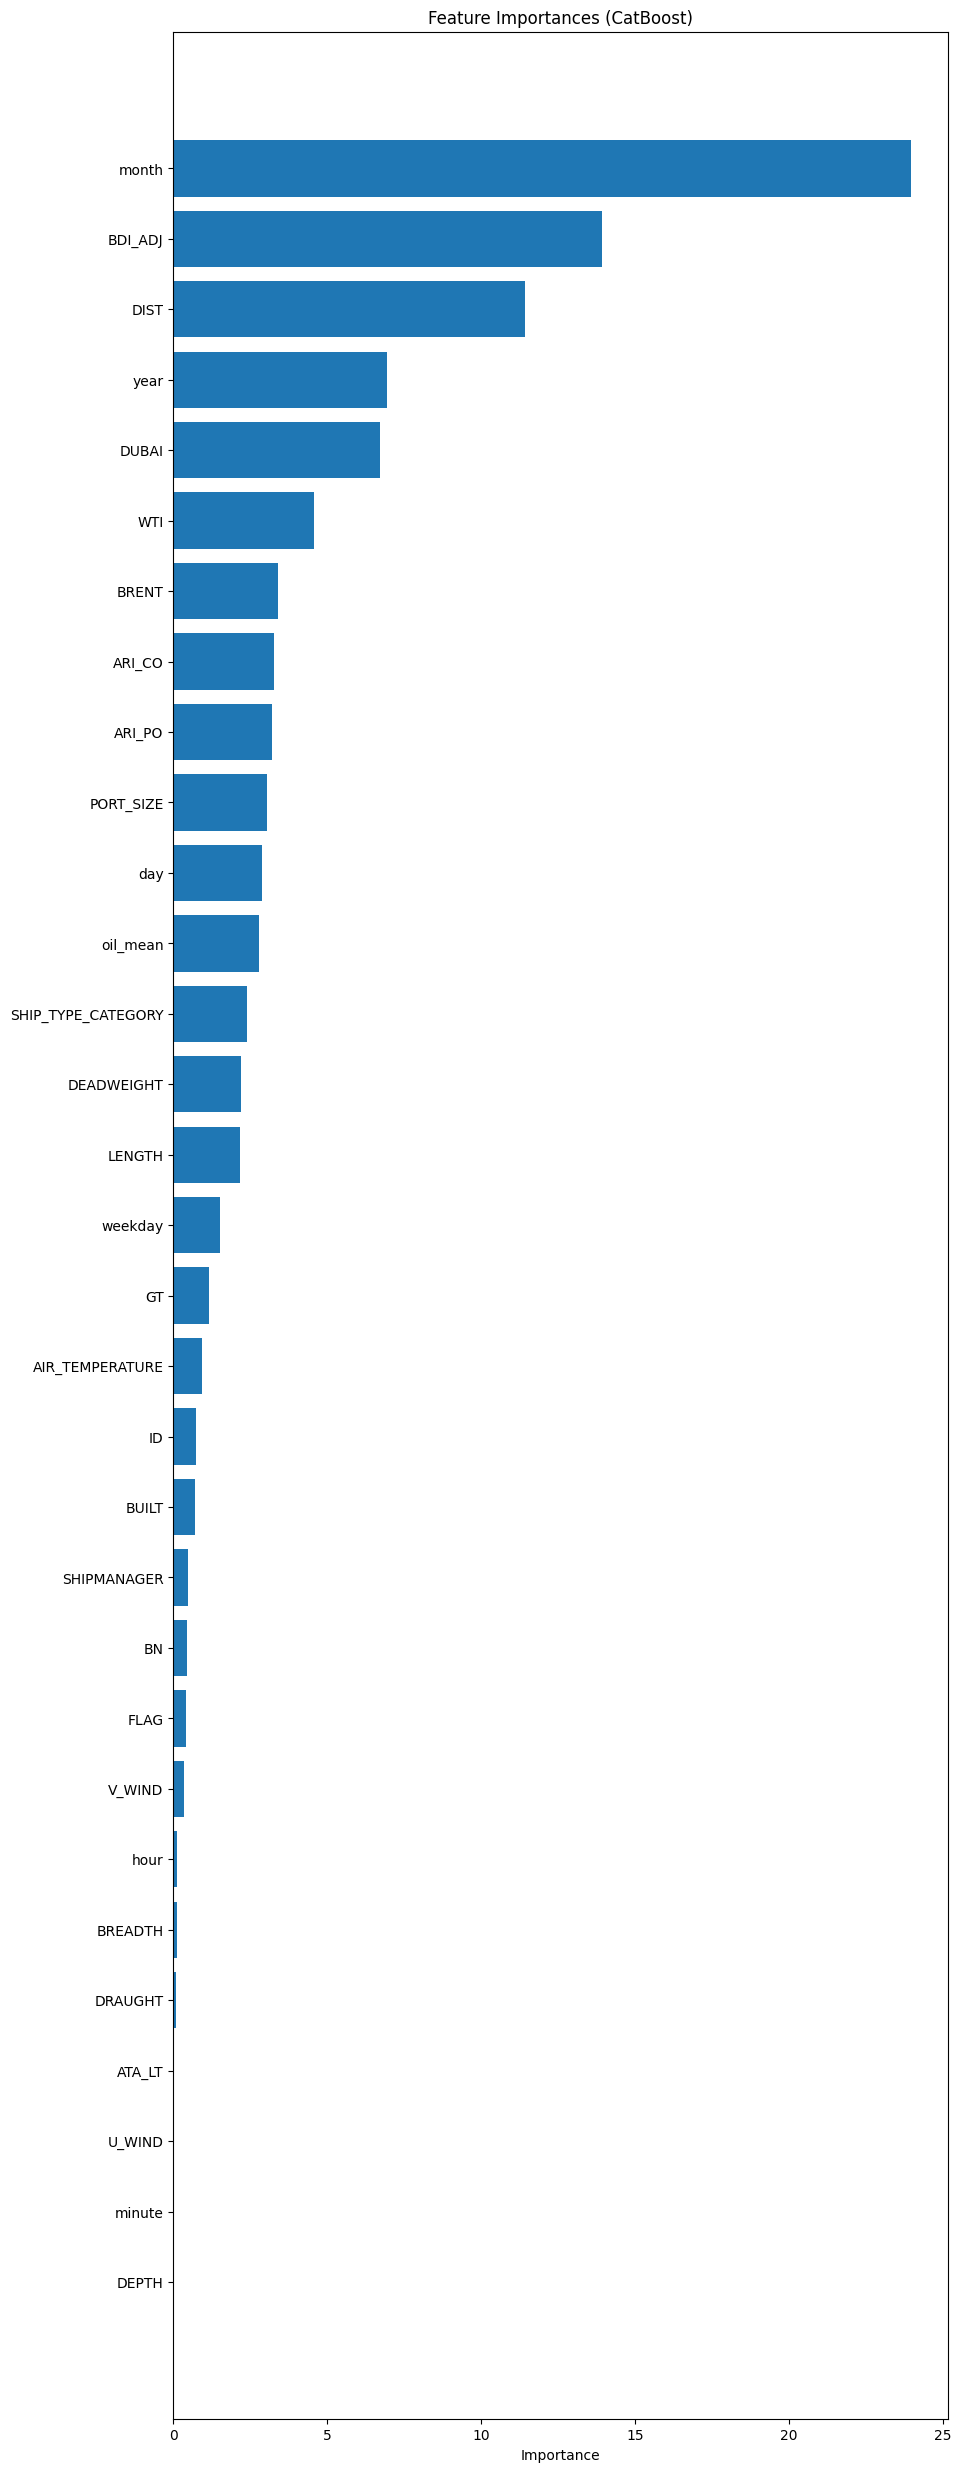

In [6]:
import catboost
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

def train_and_evaluate(model, model_name, X_train, y_train, cat_features=None):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train, cat_features=cat_features)

    feature_importances = model.get_feature_importance()
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# 카테고리형 특성의 인덱스를 지정합니다.
cat_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
# CatBoost 모델로 변경
catboost_model = CatBoostRegressor()
catboost_model, catboost_feature_importances = train_and_evaluate(catboost_model, 'CatBoost', X_train, y_train, cat_features)


## 특성 중요도로부터 Feature Selection

In [7]:
threshold = 1  # Your Threshold
low_importance_features = X_train.columns[catboost_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)


## K-Fold Model Fitting & Validation

In [ ]:
X_t.head()

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,DEADWEIGHT,LENGTH,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,year,month,day,weekday
0,CN,EKP8,Bulk,30.736578,73100,220.0,42.01,43.16,40.96,1407.668330,0.001660,2020,10,15,3
1,CN,EUC8,Container,63.220425,37900,220.0,67.53,64.55,59.34,2089.046774,0.001614,2019,9,17,1
3,JP,TMR7,Cargo,0.000000,1490,70.0,43.02,43.15,41.11,1169.853455,0.000069,2020,9,18,4
4,RU,NNC2,Container,8.813725,27600,180.0,90.45,93.65,88.11,1107.944894,0.000197,2022,8,13,5
5,CN,NGG6,Container,81.435335,18100,160.0,45.75,48.89,45.92,820.288044,0.001743,2015,9,8,1


In [8]:
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import numpy as np
from tqdm import tqdm

# CatBoost 모델 초기화
catboost_model = CatBoostRegressor()

# 5-Fold 설정
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=10, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # CatBoost 모델 학습
    cat_features_idx = ['ARI_CO','ARI_PO','SHIP_TYPE_CATEGORY']
    catboost_model.fit(X_t, y_t, cat_features=cat_features_idx)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = catboost_model.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    catboost_pred = catboost_model.predict(X_test_reduced)
    catboost_pred = np.where(catboost_pred < 0, 0, catboost_pred)

    ensemble_predictions.append(catboost_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score 출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))


Processing folds:   0%|          | 0/10 [00:00<?, ?it/s]

Learning rate set to 0.102388
0:	learn: 167.9662890	total: 229ms	remaining: 3m 48s
1:	learn: 165.7438436	total: 411ms	remaining: 3m 25s
2:	learn: 163.8645105	total: 575ms	remaining: 3m 11s
3:	learn: 162.2672274	total: 734ms	remaining: 3m 2s
4:	learn: 161.0035319	total: 963ms	remaining: 3m 11s
5:	learn: 159.9117750	total: 1.17s	remaining: 3m 13s
6:	learn: 158.8194717	total: 1.51s	remaining: 3m 34s
7:	learn: 157.9329036	total: 1.82s	remaining: 3m 46s
8:	learn: 157.2523691	total: 2.17s	remaining: 3m 59s
9:	learn: 156.6430636	total: 2.53s	remaining: 4m 10s
10:	learn: 156.0853946	total: 2.88s	remaining: 4m 19s
11:	learn: 155.6068133	total: 3.2s	remaining: 4m 23s
12:	learn: 155.1717312	total: 3.48s	remaining: 4m 24s
13:	learn: 154.8500086	total: 3.7s	remaining: 4m 20s
14:	learn: 154.5146044	total: 3.87s	remaining: 4m 14s
15:	learn: 154.1226540	total: 4.05s	remaining: 4m 9s
16:	learn: 153.8503893	total: 4.23s	remaining: 4m 4s
17:	learn: 153.5797450	total: 4.44s	remaining: 4m 2s
18:	learn: 153

Processing folds:  10%|█         | 1/10 [03:39<32:59, 219.97s/it]

Learning rate set to 0.102388
0:	learn: 167.9196001	total: 415ms	remaining: 6m 54s
1:	learn: 165.6551399	total: 667ms	remaining: 5m 32s
2:	learn: 163.8425420	total: 1.01s	remaining: 5m 35s
3:	learn: 162.2367155	total: 1.39s	remaining: 5m 46s
4:	learn: 160.9383714	total: 1.53s	remaining: 5m 4s
5:	learn: 159.8735168	total: 1.68s	remaining: 4m 38s
6:	learn: 158.9632354	total: 1.82s	remaining: 4m 18s
7:	learn: 158.0593172	total: 2.02s	remaining: 4m 10s
8:	learn: 157.2884223	total: 2.18s	remaining: 4m
9:	learn: 156.6852142	total: 2.38s	remaining: 3m 55s
10:	learn: 156.1255460	total: 2.52s	remaining: 3m 46s
11:	learn: 155.5445008	total: 2.68s	remaining: 3m 40s
12:	learn: 155.1244361	total: 2.86s	remaining: 3m 36s
13:	learn: 154.7314462	total: 3.02s	remaining: 3m 32s
14:	learn: 154.3658198	total: 3.21s	remaining: 3m 31s
15:	learn: 154.0153451	total: 3.38s	remaining: 3m 28s
16:	learn: 153.7426805	total: 3.57s	remaining: 3m 26s
17:	learn: 153.3896830	total: 3.78s	remaining: 3m 26s
18:	learn: 15

Processing folds:  20%|██        | 2/10 [07:24<29:43, 222.89s/it]

Learning rate set to 0.102388
0:	learn: 167.9665061	total: 230ms	remaining: 3m 49s
1:	learn: 165.7414837	total: 405ms	remaining: 3m 21s
2:	learn: 163.9029569	total: 592ms	remaining: 3m 16s
3:	learn: 162.3018840	total: 799ms	remaining: 3m 18s
4:	learn: 161.0219267	total: 981ms	remaining: 3m 15s
5:	learn: 159.9266672	total: 1.16s	remaining: 3m 12s
6:	learn: 159.0122083	total: 1.3s	remaining: 3m 3s
7:	learn: 158.1644285	total: 1.48s	remaining: 3m 3s
8:	learn: 157.5264167	total: 1.61s	remaining: 2m 57s
9:	learn: 156.8985302	total: 1.78s	remaining: 2m 56s
10:	learn: 156.4013927	total: 1.98s	remaining: 2m 57s
11:	learn: 155.9708661	total: 2.17s	remaining: 2m 59s
12:	learn: 155.5059600	total: 2.39s	remaining: 3m 1s
13:	learn: 155.0912358	total: 2.54s	remaining: 2m 58s
14:	learn: 154.7371653	total: 2.7s	remaining: 2m 57s
15:	learn: 154.4938400	total: 2.88s	remaining: 2m 56s
16:	learn: 154.1165467	total: 3.06s	remaining: 2m 56s
17:	learn: 153.8390538	total: 3.24s	remaining: 2m 56s
18:	learn: 15

Processing folds:  30%|███       | 3/10 [11:13<26:19, 225.60s/it]

Learning rate set to 0.102388
0:	learn: 167.1962580	total: 221ms	remaining: 3m 40s
1:	learn: 164.9502800	total: 370ms	remaining: 3m 4s
2:	learn: 163.0537315	total: 544ms	remaining: 3m
3:	learn: 161.5437622	total: 668ms	remaining: 2m 46s
4:	learn: 160.2255097	total: 880ms	remaining: 2m 55s
5:	learn: 159.0994045	total: 1.07s	remaining: 2m 57s
6:	learn: 158.0422149	total: 1.26s	remaining: 2m 58s
7:	learn: 157.2568158	total: 1.45s	remaining: 2m 59s
8:	learn: 156.4867407	total: 1.63s	remaining: 2m 58s
9:	learn: 155.8284255	total: 1.81s	remaining: 2m 59s
10:	learn: 155.3115911	total: 2.02s	remaining: 3m 1s
11:	learn: 154.8528195	total: 2.18s	remaining: 2m 59s
12:	learn: 154.4617741	total: 2.34s	remaining: 2m 57s
13:	learn: 154.1241949	total: 2.46s	remaining: 2m 52s
14:	learn: 153.7659729	total: 2.65s	remaining: 2m 53s
15:	learn: 153.4647469	total: 2.83s	remaining: 2m 54s
16:	learn: 153.1001690	total: 3.05s	remaining: 2m 56s
17:	learn: 152.8275641	total: 3.24s	remaining: 2m 56s
18:	learn: 152

Processing folds:  40%|████      | 4/10 [14:57<22:29, 224.85s/it]

Learning rate set to 0.102388
0:	learn: 167.2485817	total: 220ms	remaining: 3m 39s
1:	learn: 164.9958969	total: 353ms	remaining: 2m 55s
2:	learn: 163.1038995	total: 534ms	remaining: 2m 57s
3:	learn: 161.5690057	total: 656ms	remaining: 2m 43s
4:	learn: 160.2626339	total: 876ms	remaining: 2m 54s
5:	learn: 159.1213800	total: 1.01s	remaining: 2m 46s
6:	learn: 158.2253753	total: 1.17s	remaining: 2m 45s
7:	learn: 157.4324423	total: 1.35s	remaining: 2m 46s
8:	learn: 156.7611597	total: 1.53s	remaining: 2m 48s
9:	learn: 155.8806643	total: 1.71s	remaining: 2m 48s
10:	learn: 155.2876339	total: 1.9s	remaining: 2m 51s
11:	learn: 154.7736273	total: 2.08s	remaining: 2m 51s
12:	learn: 154.3235881	total: 2.27s	remaining: 2m 52s
13:	learn: 153.9565905	total: 2.44s	remaining: 2m 51s
14:	learn: 153.6557648	total: 2.6s	remaining: 2m 50s
15:	learn: 153.3128137	total: 2.77s	remaining: 2m 50s
16:	learn: 153.0301851	total: 3s	remaining: 2m 53s
17:	learn: 152.7330545	total: 3.22s	remaining: 2m 55s
18:	learn: 15

Processing folds:  50%|█████     | 5/10 [18:38<18:36, 223.31s/it]

Learning rate set to 0.102388
0:	learn: 168.0671912	total: 219ms	remaining: 3m 38s
1:	learn: 165.8150175	total: 417ms	remaining: 3m 28s
2:	learn: 163.9690600	total: 618ms	remaining: 3m 25s
3:	learn: 162.4105338	total: 785ms	remaining: 3m 15s
4:	learn: 161.0683525	total: 987ms	remaining: 3m 16s
5:	learn: 159.9531838	total: 1.15s	remaining: 3m 9s
6:	learn: 159.0202915	total: 1.31s	remaining: 3m 6s
7:	learn: 158.2460305	total: 1.46s	remaining: 3m 1s
8:	learn: 157.5626121	total: 1.64s	remaining: 3m
9:	learn: 156.9538176	total: 1.81s	remaining: 2m 59s
10:	learn: 156.4322051	total: 1.95s	remaining: 2m 55s
11:	learn: 155.9454243	total: 2.13s	remaining: 2m 55s
12:	learn: 155.4690545	total: 2.35s	remaining: 2m 58s
13:	learn: 155.0938684	total: 2.53s	remaining: 2m 57s
14:	learn: 154.6774931	total: 2.71s	remaining: 2m 57s
15:	learn: 154.4346446	total: 2.83s	remaining: 2m 54s
16:	learn: 154.0583854	total: 3.12s	remaining: 3m
17:	learn: 153.8302173	total: 3.44s	remaining: 3m 7s
18:	learn: 153.52328

Processing folds:  60%|██████    | 6/10 [22:20<14:52, 223.16s/it]

Learning rate set to 0.102388
0:	learn: 168.4007066	total: 229ms	remaining: 3m 48s
1:	learn: 166.1223480	total: 440ms	remaining: 3m 39s
2:	learn: 164.3074534	total: 631ms	remaining: 3m 29s
3:	learn: 162.7758516	total: 808ms	remaining: 3m 21s
4:	learn: 161.4699834	total: 1s	remaining: 3m 19s
5:	learn: 160.3465736	total: 1.17s	remaining: 3m 14s
6:	learn: 159.4330885	total: 1.34s	remaining: 3m 10s
7:	learn: 158.6937605	total: 1.49s	remaining: 3m 4s
8:	learn: 157.9217937	total: 1.66s	remaining: 3m 2s
9:	learn: 157.2926140	total: 1.86s	remaining: 3m 4s
10:	learn: 156.7657234	total: 2.04s	remaining: 3m 2s
11:	learn: 156.3067895	total: 2.22s	remaining: 3m 3s
12:	learn: 155.8953205	total: 2.42s	remaining: 3m 4s
13:	learn: 155.5577081	total: 2.63s	remaining: 3m 5s
14:	learn: 155.1725348	total: 2.84s	remaining: 3m 6s
15:	learn: 154.7905141	total: 3.07s	remaining: 3m 8s
16:	learn: 154.4818983	total: 3.24s	remaining: 3m 7s
17:	learn: 154.1827824	total: 3.47s	remaining: 3m 9s
18:	learn: 153.9683753

Processing folds:  70%|███████   | 7/10 [26:01<11:06, 222.25s/it]

Learning rate set to 0.102388
0:	learn: 167.5348461	total: 399ms	remaining: 6m 38s
1:	learn: 165.2522411	total: 638ms	remaining: 5m 18s
2:	learn: 163.4426282	total: 947ms	remaining: 5m 14s
3:	learn: 161.8915409	total: 1.07s	remaining: 4m 26s
4:	learn: 160.5537970	total: 1.28s	remaining: 4m 14s
5:	learn: 159.3921247	total: 1.47s	remaining: 4m 3s
6:	learn: 158.4116636	total: 1.69s	remaining: 3m 59s
7:	learn: 157.5463084	total: 1.83s	remaining: 3m 47s
8:	learn: 156.8847681	total: 1.98s	remaining: 3m 38s
9:	learn: 156.2719194	total: 2.17s	remaining: 3m 34s
10:	learn: 155.7538761	total: 2.36s	remaining: 3m 32s
11:	learn: 155.0114557	total: 2.52s	remaining: 3m 27s
12:	learn: 154.6355563	total: 2.7s	remaining: 3m 25s
13:	learn: 154.1885305	total: 2.86s	remaining: 3m 21s
14:	learn: 153.8668352	total: 2.98s	remaining: 3m 16s
15:	learn: 153.5874313	total: 3.13s	remaining: 3m 12s
16:	learn: 153.2958384	total: 3.32s	remaining: 3m 12s
17:	learn: 152.9389333	total: 3.56s	remaining: 3m 14s
18:	learn:

Processing folds:  80%|████████  | 8/10 [29:45<07:25, 222.92s/it]

Learning rate set to 0.102388
0:	learn: 168.1344841	total: 223ms	remaining: 3m 42s
1:	learn: 165.9026336	total: 364ms	remaining: 3m 1s
2:	learn: 164.0407116	total: 551ms	remaining: 3m 2s
3:	learn: 162.4514509	total: 765ms	remaining: 3m 10s
4:	learn: 161.0862362	total: 910ms	remaining: 3m 1s
5:	learn: 159.9905413	total: 1.08s	remaining: 2m 59s
6:	learn: 159.0468831	total: 1.24s	remaining: 2m 56s
7:	learn: 158.2182044	total: 1.51s	remaining: 3m 7s
8:	learn: 157.5265056	total: 1.84s	remaining: 3m 23s
9:	learn: 156.9227803	total: 2.17s	remaining: 3m 34s
10:	learn: 156.4041834	total: 2.52s	remaining: 3m 46s
11:	learn: 156.0162679	total: 2.81s	remaining: 3m 51s
12:	learn: 155.5347083	total: 3.21s	remaining: 4m 4s
13:	learn: 155.1576453	total: 3.56s	remaining: 4m 10s
14:	learn: 154.8462040	total: 3.82s	remaining: 4m 10s
15:	learn: 154.5668145	total: 3.96s	remaining: 4m 3s
16:	learn: 154.2866307	total: 4.14s	remaining: 3m 59s
17:	learn: 153.9184340	total: 4.33s	remaining: 3m 56s
18:	learn: 153

Processing folds:  90%|█████████ | 9/10 [33:33<03:44, 224.53s/it]

Learning rate set to 0.102388
0:	learn: 167.5076300	total: 228ms	remaining: 3m 47s
1:	learn: 165.2100925	total: 360ms	remaining: 2m 59s
2:	learn: 163.3847926	total: 569ms	remaining: 3m 8s
3:	learn: 161.8653625	total: 803ms	remaining: 3m 20s
4:	learn: 160.5361039	total: 1.2s	remaining: 3m 58s
5:	learn: 159.3890899	total: 1.55s	remaining: 4m 16s
6:	learn: 158.4158511	total: 1.92s	remaining: 4m 32s
7:	learn: 157.5476509	total: 2.19s	remaining: 4m 31s
8:	learn: 156.8946334	total: 2.48s	remaining: 4m 33s
9:	learn: 156.3010998	total: 2.81s	remaining: 4m 38s
10:	learn: 155.7941193	total: 3.13s	remaining: 4m 41s
11:	learn: 155.2917508	total: 3.3s	remaining: 4m 31s
12:	learn: 154.8745390	total: 3.5s	remaining: 4m 25s
13:	learn: 154.4840722	total: 3.65s	remaining: 4m 17s
14:	learn: 154.1497714	total: 3.84s	remaining: 4m 12s
15:	learn: 153.8489939	total: 4.09s	remaining: 4m 11s
16:	learn: 153.5784526	total: 4.27s	remaining: 4m 6s
17:	learn: 153.3181672	total: 4.47s	remaining: 4m 3s
18:	learn: 152

Processing folds: 100%|██████████| 10/10 [37:18<00:00, 223.85s/it]

Validation : MAE scores for each fold: [42.34040627358238, 41.27586065990979, 42.44198171832582, 43.61621095774634, 43.62227466402887, 42.503108186821805, 42.738892173042586, 42.93940159374533, 41.723937700550195, 42.11526766128548]
Validation : MAE: 42.53173415890386


## Submission

In [9]:
submit = pd.read_csv('./sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('./catboost_submit_10월14일.csv', index=False)

In [ ]:
train